Prepare data to train a Neural ODE that learns time derivatives of the four bulk moments:
- $\frac{dq_c}{dt}$ (cloud water)
- $\frac{dn_c}{dt}$ (cloud number)
- $\frac{dq_r}{dt}$ (rain water)
- $\frac{dn_r}{dt}$ (rain number)

**Ideas:**
1. Load test data and average over 100 stochastic instances
2. Extract the 4 bulk moments + environmental parameters
3. Compute time derivatives using finite differences
4. Create train/test split
6. Normalize and prepare final datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load test data
data_path = Path('./data/test_arr.npz')
data = np.load(data_path)

data_array = data['data']  # shape: (3599, 18, 100, 100)
mask_array = data['mask']  # shape: (3599, 18, 100, 100)

# time steps, features, initial conds, stochastic realizations

# Feature indices
feature_info = {
    'qc': 1,  # cloud water
    'nc': 2,  # cloud number
    'qr': 3,  # rain water
    'nr': 4,  # rain number
    'q_w0': 14,  # initial water mixing ratio
    'r_0': 15,   # initial droplet radius
    'nu': 16     # shape parameter
}

bulk_moment_indices = [1, 2, 3, 4]  # qc, nc, qr, nr
env_param_indices = [14, 15, 16]    # q_w0, r_0, nu
dt = 20.0  # timestep in seconds

# Apply mask
data_masked = np.ma.MaskedArray(data_array, mask=mask_array)

Average over 100 instances

In [3]:
data_averaged = data_masked.mean(axis=3)

print(f"Averaged data shape: {data_averaged.shape}") # (time steps, features, ICs)

n_time, n_features, n_ics = data_averaged.shape

Averaged data shape: (3599, 18, 100)


Since each IC has different trajectory lengths, we need to process them separately.

In [4]:
# Extract valid trajectories for each IC
trajectories = []
trajectory_lengths = []

for ic_idx in range(n_ics):
    # Check which timesteps are valid (use first bulk moment as reference)
    valid_mask = ~data_averaged[:, bulk_moment_indices[0], ic_idx].mask
    n_valid = valid_mask.sum()
    
    if n_valid > 1:  # Need at least 2 points to compute derivative
        # Extract valid timesteps for all features
        trajectory = data_averaged[valid_mask, :, ic_idx].data
        trajectories.append(trajectory)
        trajectory_lengths.append(n_valid)

print(f"Number of valid ICs: {len(trajectories)}")
print(f"Trajectory lengths:")
print(f"  Min: {min(trajectory_lengths)} timesteps ({min(trajectory_lengths) * dt} seconds)")
print(f"  Max: {max(trajectory_lengths)} timesteps ({max(trajectory_lengths) * dt} seconds)")
print(f"  Mean: {np.mean(trajectory_lengths):.1f} timesteps ({np.mean(trajectory_lengths) * dt:.1f} seconds)")

Number of valid ICs: 100
Trajectory lengths:
  Min: 59 timesteps (1180.0 seconds)
  Max: 2399 timesteps (47980.0 seconds)
  Mean: 488.3 timesteps (9766.2 seconds)


For each trajectory, I compute $\frac{dM}{dt}$ using finite differences
$$\frac{dM}{dt} \approx \frac{M(t+\Delta t) - M(t)}{\Delta t}$$

Input features (x):
- [0:4] - Bulk moments: qc, nc, qr, nr
- [4:7] - Env params: q_w0, r_0, nu

Output targets (y):
- [0:4] - Derivatives: dqc/dt, dnc/dt, dqr/dt, dnr/dt

In [5]:
# Prepare input-output pairs for NODE training
X_list = []  # Input features
Y_list = []  # Time derivatives (targets)
T_list = []  # Time values (for reference)

for traj_idx, trajectory in enumerate(trajectories):
    n_steps = len(trajectory)
    
    # Extract bulk moments and environmental parameters
    bulk_moments = trajectory[:, bulk_moment_indices]  # shape: (n_steps, 4)
    env_params = trajectory[:, env_param_indices]      # shape: (n_steps, 3)
    
    # Compute time derivatives using forward difference
    # derivatives at time t = (M[t+1] - M[t]) / dt
    derivatives = np.diff(bulk_moments, axis=0) / dt  # shape: (n_steps-1, 4)
    
    # Input: state at time t (use all but last timestep)
    moments_t = bulk_moments[:-1, :]  # shape: (n_steps-1, 4)
    env_t = env_params[:-1, :]        # shape: (n_steps-1, 3)
    
    # Concatenate moments and environmental parameters
    X = np.concatenate([moments_t, env_t], axis=1)  # shape: (n_steps-1, 7)
    Y = derivatives  # shape: (n_steps-1, 4)
    
    # Time values
    T = np.arange(n_steps - 1) * dt
    
    X_list.append(X)
    Y_list.append(Y)
    T_list.append(T)

# Concatenate all trajectories into single arrays
X_all = np.vstack(X_list)  # shape: (total_samples, 7)
Y_all = np.vstack(Y_list)  # shape: (total_samples, 4)
T_all = np.hstack(T_list)  # shape: (total_samples,)

print(f"Total training samples: {X_all.shape[0]}")
print(f"Input features (X): {X_all.shape[1]} (4 bulk moments + 3 env params)")
print(f"Output targets (Y): {Y_all.shape[1]} (derivatives of 4 bulk moments)")

Total training samples: 48731
Input features (X): 7 (4 bulk moments + 3 env params)
Output targets (Y): 4 (derivatives of 4 bulk moments)


## 6. Train/Test Split

Split data into 80% training and 20% testing.

In [6]:
# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y_all, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nSplit ratio: {X_train.shape[0] / X_all.shape[0]:.1%} train, {X_test.shape[0] / X_all.shape[0]:.1%} test")

Training set: 38984 samples
Test set: 9747 samples

Split ratio: 80.0% train, 20.0% test


## 7. Normalize Data

Normalize inputs and outputs using StandardScaler (fit on training data only).

In [7]:
# Create scalers
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit on training data only
X_train_norm = scaler_X.fit_transform(X_train)
Y_train_norm = scaler_Y.fit_transform(Y_train)

# Transform test data using training statistics
X_test_norm = scaler_X.transform(X_test)
Y_test_norm = scaler_Y.transform(Y_test)

print("Normalization complete!")
print(f"\nNormalized training data:")
print(f"  X_train mean: {X_train_norm.mean(axis=0)}")
print(f"  X_train std: {X_train_norm.std(axis=0)}")
print(f"  Y_train mean: {Y_train_norm.mean(axis=0)}")
print(f"  Y_train std: {Y_train_norm.std(axis=0)}")

Normalization complete!

Normalized training data:
  X_train mean: [-7.44235031e-15  4.03181490e-15 -3.69314334e-15  4.28014628e-15
 -1.69219898e-13 -1.98006373e-13  2.89682089e-16]
  X_train std: [1. 1. 1. 1. 1. 1. 1.]
  Y_train mean: [-1.09338485e-15  2.33172751e-15 -8.06017388e-16  1.71246718e-16]
  Y_train std: [1. 1. 1. 1.]


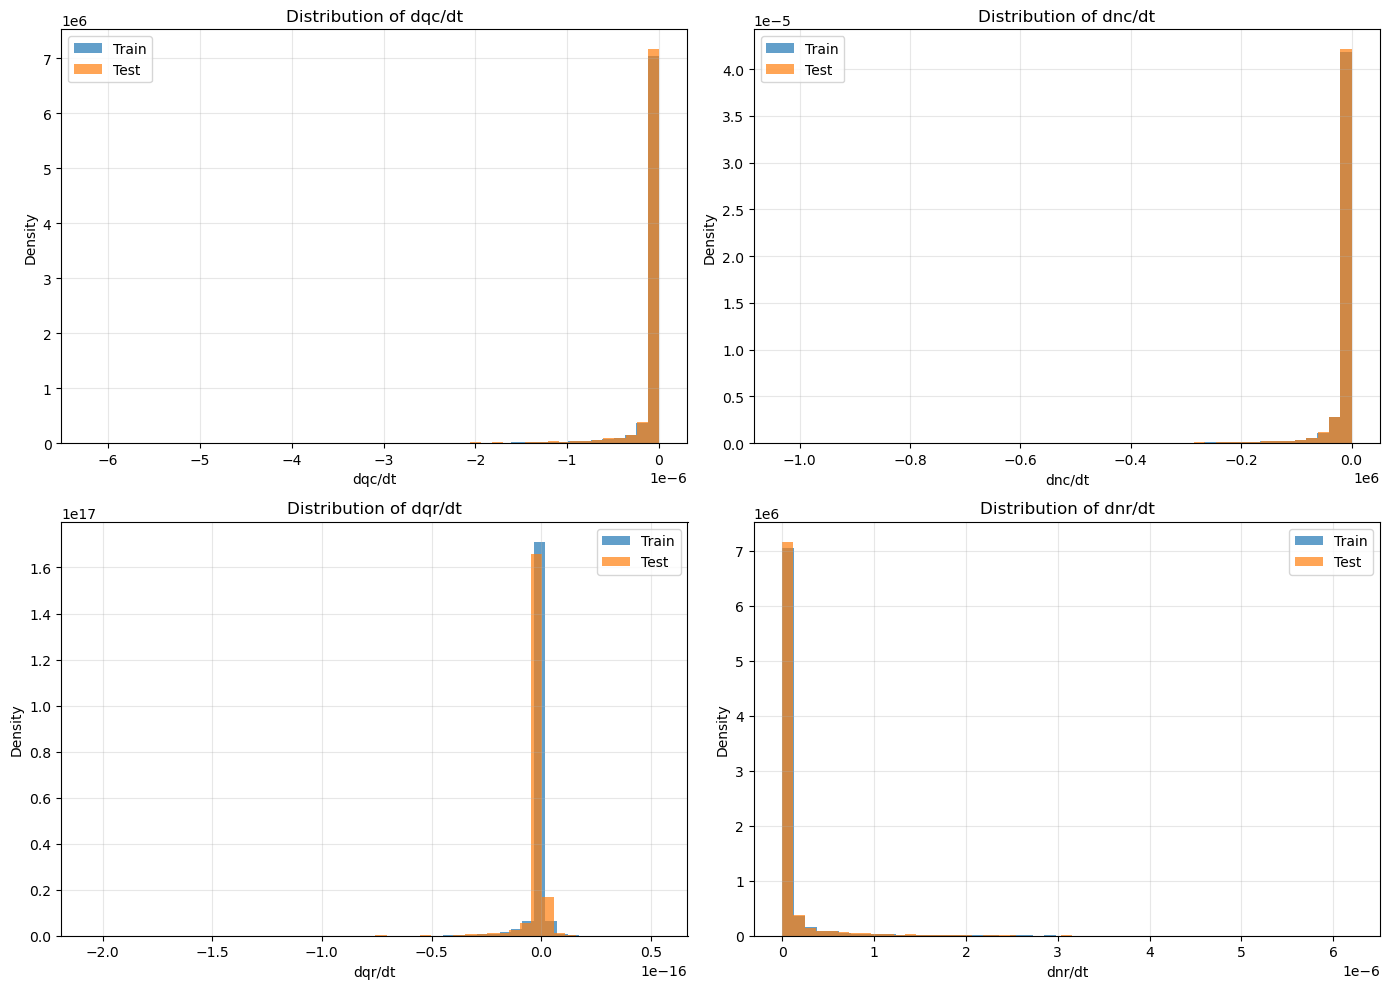

Saved: derivatives_distribution.png


In [8]:
# Plot distribution of time derivatives
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
deriv_names = ['dqc/dt', 'dnc/dt', 'dqr/dt', 'dnr/dt']

for i, (ax, name) in enumerate(zip(axes.flat, deriv_names)):
    # Plot histogram
    ax.hist(Y_train[:, i], bins=50, alpha=0.7, label='Train', density=True)
    ax.hist(Y_test[:, i], bins=50, alpha=0.7, label='Test', density=True)
    ax.set_xlabel(name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('derivatives_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: derivatives_distribution.png")

Save the preprocessed data and scalers for training the Neural ODE.

In [10]:
# Save preprocessed data
output_dir = Path('./data')
output_dir.mkdir(exist_ok=True)

# Save as numpy arrays
np.savez(
    output_dir / 'node_preprocessed.npz',
    X_train=X_train,
    X_test=X_test,
    Y_train=Y_train,
    Y_test=Y_test,
    X_train_norm=X_train_norm,
    X_test_norm=X_test_norm,
    Y_train_norm=Y_train_norm,
    Y_test_norm=Y_test_norm
)

# Save scalers
with open(output_dir / 'scalers.pkl', 'wb') as f:
    pickle.dump({'scaler_X': scaler_X, 'scaler_Y': scaler_Y}, f)

print("✓ Saved preprocessed data to:")
print(f"  - {output_dir / 'node_preprocessed.npz'}")
print(f"  - {output_dir / 'scalers.pkl'}")

✓ Saved preprocessed data to:
  - data/node_preprocessed.npz
  - data/scalers.pkl
